In [1]:
import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter)
import matplotlib as mpl 
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np

from src import utils, cesm_utils, plots
import src.models as models
from src.inputs import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Functions for Figure 1
def load_global_sst_data(filepath):
    """Function to load global SST datasets and select the common analysis period"""
    sst_data = utils.open_dataset(filepath)

    sst_data_seasonal = sst_data.resample(time='QS-DEC', label='left').mean()
    sst_data_djf = sst_data_seasonal.sel(time=sst_data_seasonal.time.dt.month.isin([12])).resample(time='1Y').mean()

    return sst_data_djf['sst'].sel(time=slice("1951-01", "2015-12"))


def sign_agreement_mask(map_da, threshold):
    """Create a map mask where all ensemble members / observations agree on sign."""

    signs = np.sign(map_da)
    sum_signs = np.sum(signs, axis=0)
    mask = np.abs(sum_signs) >= threshold

    return mask

In [3]:
# Load observation data
prect_sources = ["GPCC", "CRUT", "APHR"]
sst_sources = ["ERSST", "HADISST", "COBESST"]

obs_msea_prect_anomalies = {source: utils.get_obs_msea_prect_anomaly_timeseries_mam(source) for source in prect_sources}
obs_nino34_sst_anomalies = {source: utils.get_obs_nino34_sst_anomaly_timeseries_djf(source) for source in sst_sources}
obs_global_sst_climatology = {key: load_global_sst_data(path) for key, path in sst_reanalysis_source_to_file.items()}

obs_msea_prect_anomalies_list = [
    obs_msea_prect_anomalies["GPCC"],
    obs_msea_prect_anomalies["CRUT"],
    obs_msea_prect_anomalies["APHR"],
]

obs_nino34_sst_anomalies_list = [
    obs_nino34_sst_anomalies["ERSST"],
    obs_nino34_sst_anomalies["HADISST"],
    obs_nino34_sst_anomalies["COBESST"],
]

obs_global_sst_climatology_list = [
    obs_global_sst_climatology["ERSST"],
    obs_global_sst_climatology["HADISST"],
    obs_global_sst_climatology["COBESST"],
]

In [ ]:
# Load CESM data
ensemble_members = models.CESM2_ensemble_members # List of CESM2 Ensemble Members

cesm_global_djf_sst_map = cesm_utils.process_cesm_ensemble(ensemble_members, "SST.global.1900_2100")  # annual global DJF ssts
cesm_msea_mam_prect_timeseries = cesm_utils.process_cesm_ensemble(ensemble_members, "PRECT.MSEA")  # monthly MSEA ssts

# select same time period as observations for comparison
cesm_global_djf_sst_map = cesm_global_djf_sst_map['SST'].sel(time=slice('1951', '2015'))
cesm_msea_mam_prect_timeseries = cesm_msea_mam_prect_timeseries.sel(time=slice('1951', '2015'))

In [5]:
# CESM Regression: regress MSEA MAM index onto global DJF SSTs
regression_cesm = utils.regress_index_onto_field(cesm_global_djf_sst_map, cesm_msea_mam_prect_timeseries)
regression_cesm_mean = regression_cesm.mean(dim='ensemble')
mask_cesm = sign_agreement_mask(regression_cesm, threshold=100)

# Regrid observed SSTs to CESM grid
obs_global_sst_climatology_list_regridded = utils.regrid_observed_ssts_to_cesm_grid(
    obs_global_sst_climatology_list, regression_cesm_mean
    )

# Observed Regression: regress MSEA MAM index onto (regridded) global DJF SSTs
regression_obs = utils.regress_index_list_onto_field_list(obs_global_sst_climatology_list_regridded, obs_msea_prect_anomalies_list)
regression_obs_mean = regression_obs.mean(dim='datasets')
mask_obs = sign_agreement_mask(regression_obs, threshold=9)

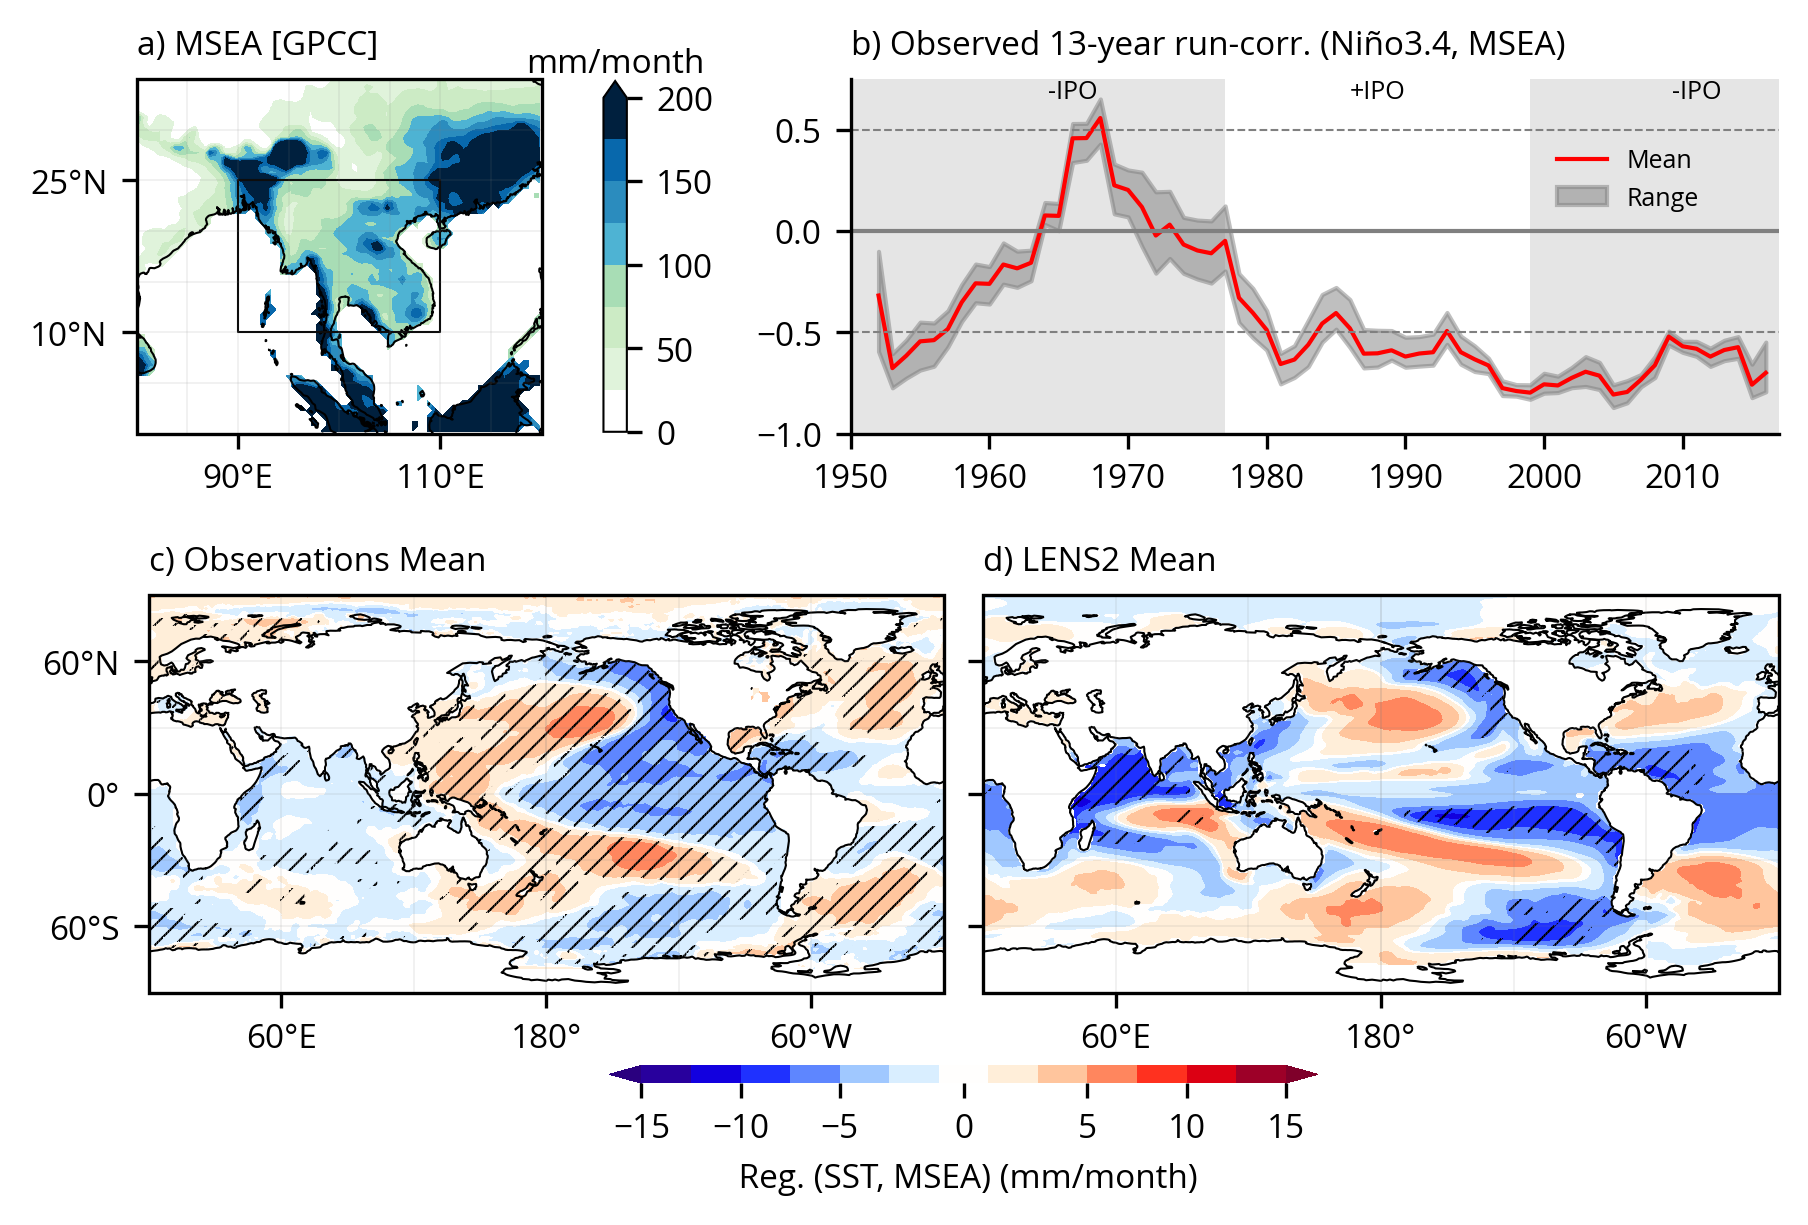

In [6]:
utils.set_matplotlib_font("Open Sans")
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
    
color = 'black'

mpl.rcParams.update({
    'axes.edgecolor': color,      # Color of the axes spines
    'xtick.color': color,         # Color of the x-axis ticks
    'ytick.color': color,         # Color of the y-axis ticks
    'xtick.labelcolor': color,    # Color of the x-axis tick labels
    'ytick.labelcolor': color,    # Color of the y-axis tick labels
    'grid.color': color,          # Color of the grid lines
    'axes.labelcolor': color,     # Color of the axis labels
    'axes.titlecolor': color,     # Color of the plot titles
})

mpl.rcParams['hatch.linewidth'] = 0.5  # previous pdf hatch linewidth

mpl.rcParams.update({
    'font.size': 8, 
    'axes.titlesize': 8, 
    'axes.labelsize': 8,
    'xtick.labelsize': 8, 
    'ytick.labelsize': 8, 
    'legend.fontsize': 8,
    'figure.titlesize': 8
})

fig_width_cm = 15 
fig_height_cm = 10
fig_width_in = fig_width_cm / 2.54
fig_height_in = fig_height_cm / 2.54

fig = plt.figure(figsize=(fig_width_in, fig_height_in), dpi=300)

gs1 = GridSpec(1, 2, top=0.95, bottom=0.65, left=0.03, right=0.99, wspace=0.2, width_ratios=[0.4, 0.6])
ax1 = fig.add_subplot(gs1[0, 0], projection=ccrs.PlateCarree(central_longitude=180))
ax2 = fig.add_subplot(gs1[0, 1])

gs2 = GridSpec(1, 2, top=0.63, bottom=0.06, left=0.07, right=0.99, hspace = 0.28, wspace=0.05)
ax3 = fig.add_subplot(gs2[0, 0], projection=ccrs.PlateCarree(central_longitude=180))
ax4 = fig.add_subplot(gs2[0, 1], projection=ccrs.PlateCarree(central_longitude=180))

############## Figure 1a ##############
plots.plot_msea_precipation_climatology("GPCC", fig, ax1)

############## Figure 1b ##############
plots.plot_runcorr_statistics_timeseries(obs_nino34_sst_anomalies_list,
                                   obs_msea_prect_anomalies_list, ax2,
                                   window=13)

############## Figure 1c ##############
plots.plot_regression_map(regression_obs_mean, mask_obs, ax3)

############## Figure 1d ##############
# add cyclic point at lon=320 (white vertical line)
regression_cesm_mean.sel(lon=320, method='nearest')[:] = regression_cesm_mean.sel(lon=321, method='nearest')
im = plots.plot_regression_map(regression_cesm_mean, mask_cesm, ax4)

#######################################

# Map axes
for ax in [ax3]:
    ax.set_yticklabels([-60, 0, 60], fontsize=8)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_xticklabels([60, 180, 300], fontsize=8)
    ax.xaxis.set_major_formatter(lon_formatter)
for ax in [ax4]:
    ax.set_yticklabels([], fontsize=8)
    
# Set subplot labels
titles = ["a) MSEA [GPCC]", "b) Observed 13-year run-corr. (Niño3.4, MSEA)", "c) Observations Mean", "d) LENS2 Mean"]
for i, (ax, title) in enumerate(zip([ax1, ax2, ax3, ax4], titles)):
    ax.set_title(title, loc="left", fontsize=8)

# Add colorbar
cbar_ax = fig.add_axes([0.33, 0.10, 0.4, 0.015])  # [left, bottom, width, height]
cbar = fig.colorbar(im,  cax=cbar_ax, ticks=[-15, -10, -5, 0, 5, 10, 15], orientation="horizontal", shrink=0.50, label=' Reg. (SST, MSEA) (mm/month)')
cbar.ax.tick_params(labelsize=8)
cbar.outline.set_visible(False)

plt.savefig("Fig1.png")
plt.savefig("Fig1.pdf")